In [1]:
!pip install wandb

In [2]:
import os
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout

import wandb
from wandb.keras import WandbMetricsLogger

import albumentations as A

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [64]:
lr = 0.01
n_epochs = 10
batch_size = 128

In [65]:
wandb.init(project="2023-08-03_test_1", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

epoch/categorical_accuracy,▁▅▆▇█
epoch/epoch,▁▃▅▆█
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▄▃▂▁
epoch/val_categorical_accuracy,▄▃█▆▁
epoch/val_loss,▂▂▁▄█
epoch/categorical_accuracy,0.71295
epoch/epoch,4
epoch/learning_rate,0.001
epoch/loss,0.81741
epoch/val_categorical_accuracy,0.09598


In [66]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    os.environ["TF_DETERMINISTIC_OPS"] = "true"
    

set_seed(42)

In [67]:
PATH_IMGS = "/kaggle/input/cifar10/cifar10/train/"

ids = []
labels = []
label2index = {
    'airplane': 0,
    'horse': 1,
    'truck': 2,
    'automobile': 3,
    'ship': 4,
    'dog': 5,
    'bird': 6,
    'frog': 7,
    'cat': 8,
    'deer': 9,
}

for i, folder in enumerate(os.listdir(PATH_IMGS)):
    for image_name in os.listdir(os.path.join(PATH_IMGS, folder))[:500]:
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

In [68]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'airplane',
 1: 'horse',
 2: 'truck',
 3: 'automobile',
 4: 'ship',
 5: 'dog',
 6: 'bird',
 7: 'frog',
 8: 'cat',
 9: 'deer'}

In [69]:
ids_train, ids_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, shuffle=True)

In [70]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids, y, shuffle=True, batch_size=256, transforms=None):
        self.ids = ids
        self.y = y
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.transforms = transforms
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self):
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], 10) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.transforms:
                img = self.transforms(image=img)["image"]
            
            batch_X.append(img)
        
        return np.array(batch_X) / 255., np.array(batch_y)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [71]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=90, p=1.),
        A.Blur(p=0.25),
        A.Resize(224, 224, p=1.),
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(224, 224, p=1.),
    ]
)

In [72]:
train_dataset = Dataset(ids_train, y_train, shuffle=False, batch_size=1, transforms=train_transforms)

In [73]:
X, y = train_dataset[0]
X.shape, y.shape

((1, 224, 224, 3), (1, 10))

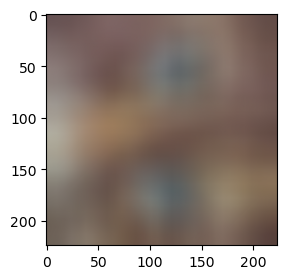

In [74]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[0][0][0])

In [75]:
train_dataset = Dataset(ids_train, y_train, shuffle=True, batch_size=batch_size, transforms=train_transforms)
valid_dataset = Dataset(ids_valid, y_valid, shuffle=False, batch_size=batch_size, transforms=valid_transforms)

In [76]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet_v2

In [77]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False)
base_model.trainable = False
# base_model.summary()

In [78]:
# base_model = vgg16.VGG16(input_shape=(32, 32, 3), include_top=False)
# base_model.trainable = False
model = Sequential(
    [
#         Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 3), activation="relu"),
#         MaxPool2D((2, 2)),
#         Conv2D(64, (3, 3), padding="same", activation="relu"),
#         MaxPool2D((2, 2)),
#         Conv2D(128, (3, 3), padding="same", activation="relu"),
#         MaxPool2D((2, 2)),
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation="softmax"),
    ]
)

In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [80]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import CategoricalAccuracy

model.compile(
    optimizer=Adam(lr=lr),
    loss="categorical_crossentropy",
    metrics=[CategoricalAccuracy()],
)

In [81]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback_early_stopping = EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=2,
    verbose=1,
    mode="max",
)

callback_save = ModelCheckpoint(
    "best.hdf5",
    monitor="val_loss",
    save_best_only=True,
)

In [82]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    verbose=1,
    callbacks=[callback_early_stopping, WandbMetricsLogger()]
)

Epoch 1/10
31/31 [==============================] - 25s 690ms/step - loss: 2.2178 - categorical_accuracy: 0.1958 - val_loss: 1.7155 - val_categorical_accuracy: 0.4029
Epoch 2/10
31/31 [==============================] - 18s 596ms/step - loss: 1.8009 - categorical_accuracy: 0.3508 - val_loss: 1.3773 - val_categorical_accuracy: 0.5324
Epoch 3/10
31/31 [==============================] - 17s 559ms/step - loss: 1.6851 - categorical_accuracy: 0.3999 - val_loss: 1.1930 - val_categorical_accuracy: 0.6071
Epoch 4/10
31/31 [==============================] - 17s 561ms/step - loss: 1.5802 - categorical_accuracy: 0.4320 - val_loss: 1.1585 - val_categorical_accuracy: 0.6060
Epoch 5/10
31/31 [==============================] - 18s 571ms/step - loss: 1.5492 - categorical_accuracy: 0.4509 - val_loss: 1.0727 - val_categorical_accuracy: 0.6317
Epoch 6/10
31/31 [==============================] - 17s 559ms/step - loss: 1.5117 - categorical_accuracy: 0.4645 - val_loss: 1.0554 - val_categorical_accuracy: 0.638

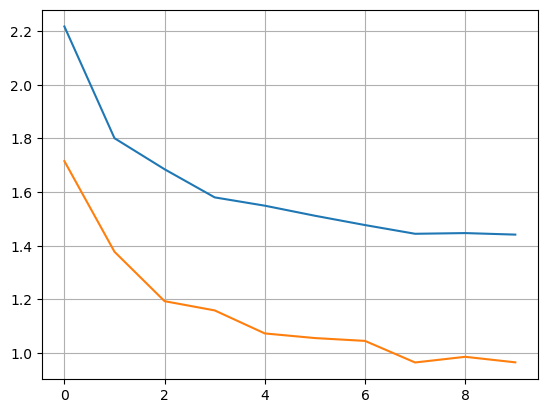

In [83]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="valid loss")
plt.grid()

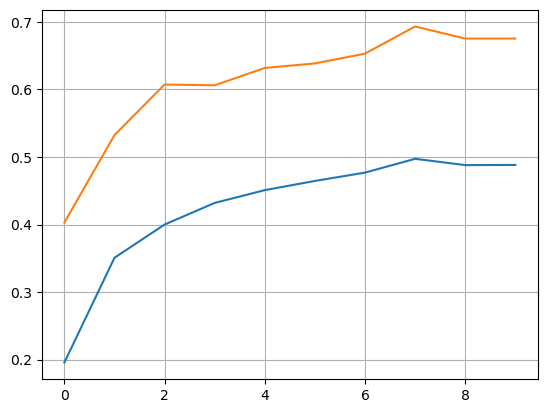

In [84]:
plt.plot(history.history["categorical_accuracy"], label="train loss")
plt.plot(history.history["val_categorical_accuracy"], label="valid loss")
plt.grid()

In [ ]:
# model = NN()
# optimizer = tf.optimizers.SGD(lr)
# train_dataset = Dataset(X_train, y_train)
# train_data = tf.data.Dataset.from_generator(train_dataset, output_types=(tf.float32, tf.uint8))
# train_data = train_data.batch(batch_size).prefetch(2)
# valid_dataset = Dataset(X_valid, y_valid)
# valid_data = tf.data.Dataset.from_generator(valid_dataset, output_types=(tf.float32, tf.uint8))
# valid_data = valid_data.batch(batch_size).prefetch(2)

# trainer = Trainer(model, optimizer, 8)
# e_train_loss, e_train_score, e_valid_loss, e_valid_score = trainer.fit(train_data, valid_data)

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_loss)
plt.plot(e_valid_loss)
plt.grid()

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(e_train_score)
plt.plot(e_valid_score)
plt.grid()

In [ ]:
df = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")

In [ ]:
df

In [ ]:
x_test_sample = df.iloc[:4, 1:].values

In [ ]:
x_test_sample = x_test_sample.astype(np.float32)
x_test_sample /= 255.

In [ ]:
test_out = model(x_test_sample)

In [ ]:
test_out.numpy().argmax(axis=1)

In [ ]:
plt.figure(figsize=(8, 8))
for i, _x in enumerate(x_test_sample, 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {test_out.numpy().argmax(axis=1)[i - 1]} Real: {df.iloc[i-1, 0]}")

In [ ]:
x_test = df.iloc[:, 1:].values
x_test = x_test.astype(np.float32)
x_test /= 255.

In [ ]:
test_out = model(x_test).numpy()

In [ ]:
y_pred_test = test_out.argmax(axis=1)
y_test = df.iloc[:, 0].values

In [ ]:
np.mean(y_pred_test == y_test)

In [ ]:
arr = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)
df_confusion_matrix = pd.DataFrame(cm, index=arr, columns=arr)

plt.figure(figsize=(8, 8))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

In [ ]:
ea = pd.DataFrame({"pred": y_pred_test, "y": y_test})

In [ ]:
ea["equal"] = ea["pred"] == ea["y"]

In [ ]:
ea[(ea["y"] == 6) & (ea["equal"] == False)]

In [ ]:
plt.figure(figsize=(8, 8))
index = [7, 16, 43, 58]
for i, _x in enumerate(x_test[index], 1):
    plt.subplot(2, 2, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {arr[y_pred_test[index[i - 1]]]} Real: {arr[y_test[index[i - 1]]]}")

In [ ]:
, 1